# Model Implementation

### Introduction

After completing the exploratory data analysis and preparing the dataset, we now move on to the core part of the project: clustering. In this section, we will implement two clustering algorithms — K-means and Hierarchical Clustering — to uncover patterns and group similar users based on their behavior. 

In [351]:
# Importing The Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [334]:
# Importing The Clean and Encoded Data
try:
    data = pd.read_csv('cleaned_segmentation_data.csv')
except:
    print('Error while loading the file')
    
data.head()

,minutes_watched,CLV,region,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,country_region_0,country_region_1,country_region_2
0,3197.0,205.42,2,False,False,False,True,False,False,False,False,False,False,True
1,63.0,149.99,0,True,False,False,False,False,False,False,False,True,False,False
2,605.0,119.00,2,False,True,False,False,False,False,False,False,False,False,True
3,20.0,240.00,2,False,False,False,True,False,False,False,False,False,False,True
4,245.0,184.36,1,False,False,False,True,False,False,False,False,False,True,False


In [335]:
data.rename(columns = {'channel_1':'Google', 'channel_2':'Facebook', 'channel_3':'YouTube','channel_4':'LinkedIn', 
                                                    'channel_5':'Twitter', 'channel_6':'Instagram', 'channel_7':'Friend', 'channel_8':'Other',
                                                    'country_region_0':'Region_0','country_region_1':'Region_1','country_region_2':'Region_2'}, inplace=True)

In [336]:
data.describe()

,minutes_watched,CLV,region
count,3834.000000,3834.000000,3834.000000
mean,1916.028169,118.383920,1.167188
std,7303.052488,70.471274,0.923055
min,0.000000,0.000000,0.000000
25%,137.000000,62.580000,0.000000
50%,480.500000,119.000000,2.000000
75%,1464.000000,149.990000,2.000000
max,288508.000000,626.400000,2.000000


In [337]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(data)

### Hierarchical Clustering

In [338]:
# Performing hierarchical clustering on the standardized data using the 'ward' method.
# The 'ward' method minimizes the sum of squared differences within all clusters.
hier_clust = linkage(segmentation_std, method = 'ward')

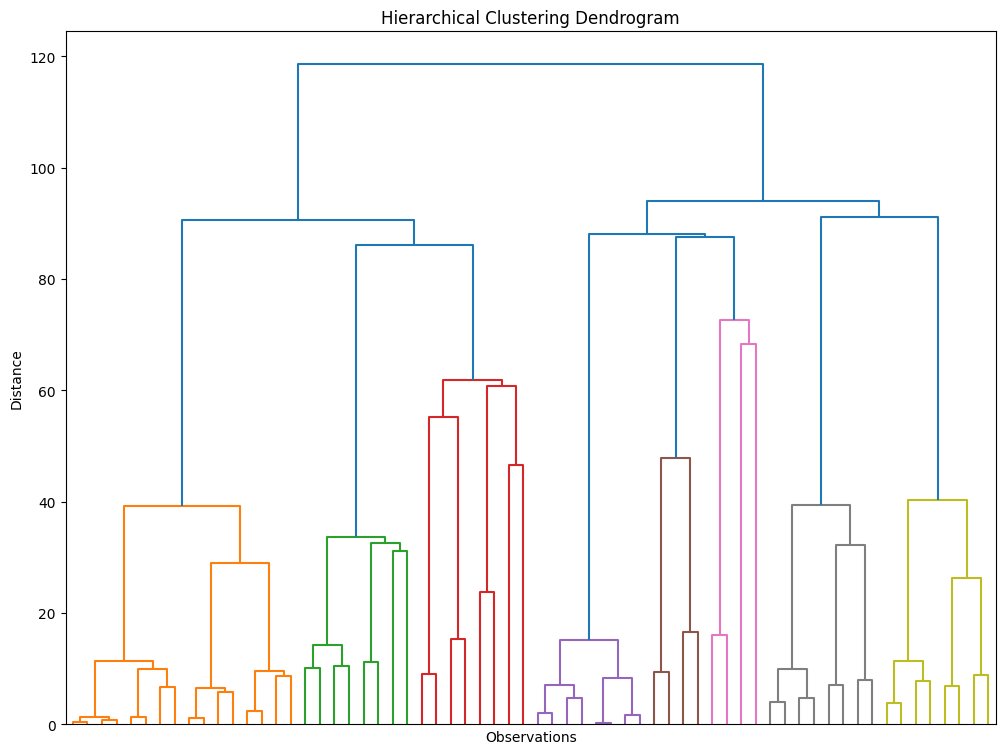

In [339]:
# Setting the figure size for the plot.
plt.figure(figsize = (12,9))

# Setting the title of the dendrogram.
plt.title('Hierarchical Clustering Dendrogram')

# Labeling the x-axis as 'Observations'.
plt.xlabel('Observations')

# Labeling the y-axis as 'Distance'.
plt.ylabel('Distance')

# Creating the dendrogram for the hierarchical clustering result.
# We're truncating the dendrogram to show only the last 5 merged clusters.
# Leaf counts and labels are not displayed.
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)

# Displaying the dendrogram.
plt.show()

The dendrogram shows the largest vertical distance between two horizontal lines when cutting at 8 clusters, suggesting that 8 is the optimal number. 

**Elbow Method**

In [340]:
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)


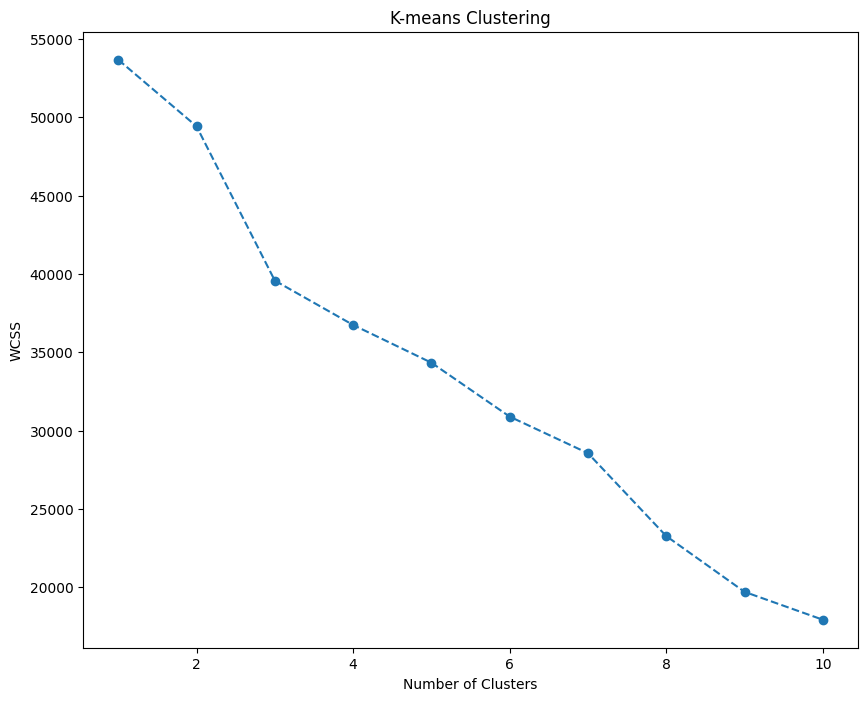

In [341]:
plt.figure(figsize = (10,8))

plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')

plt.show()

The Elbow method produced ambiguous results, suggesting several possible cluster counts (2, 4, and 7). Therefore, we will rely on the hierarchical clustering results and proceed with 8 clusters.

### K-means 

In [342]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42)

In [343]:
kmeans.fit(segmentation_std)

KMeans(random_state=42)

In [344]:
# Creating a copy of the original 'df_segmentation' dataframe to avoid modifying it directly.
df_segm_kmeans = data.copy()

# Assigning the cluster labels generated by k-means to a new column named 'Segment' in the copied dataframe.
df_segm_kmeans['Segment'] = kmeans.labels_

In [345]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment']).mean()
df_segm_analysis


# Grouping the dataframe by the 'Segment' column and calculating the mean for each segment.
# This provides a profile for each cluster based on the mean values of the original features.
df_segm_analysis = df_segm_kmeans.groupby(['Segment']).mean()

In [346]:
# Counting the number of observations in each segment.
# This is done by grouping by 'Segment' and counting the number of rows.
df_segm_analysis['N Obs'] = df_segm_kmeans.groupby(['Segment']).size()

# Calculating the proportion of observations in each segment.
# This is done by dividing the number of observations in a segment by the total number of observations.
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()


**Summary Table**

In [347]:
df_segm_analysis.round(2)

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,,
0,2767.64,108.26,1.32,0.00,1.0,0.00,0.00,0.0,0.0,0.0,0.00,0.29,0.10,0.61,306,0.08
1,1539.15,136.33,0.00,0.25,0.0,0.43,0.18,0.0,0.0,0.0,0.14,1.00,0.00,0.00,1055,0.28
2,1763.19,100.38,1.85,0.00,0.0,0.00,1.00,0.0,0.0,0.0,0.00,0.00,0.15,0.85,461,0.12
3,1800.54,111.31,1.80,1.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.20,0.80,409,0.11
4,2486.48,118.39,1.79,0.00,0.0,0.82,0.00,0.0,0.0,0.0,0.18,0.00,0.21,0.79,778,0.20
5,2006.19,113.65,1.37,0.00,0.0,0.00,0.00,0.0,0.0,1.0,0.00,0.26,0.11,0.63,478,0.12
6,985.33,93.15,1.60,0.00,0.0,0.00,0.00,1.0,0.0,0.0,0.00,0.17,0.05,0.78,58,0.02
7,1299.33,115.18,1.19,0.00,0.0,0.00,0.00,0.0,1.0,0.0,0.00,0.31,0.19,0.50,289,0.08


In [355]:
df_segm_analysis.rename({0:'Facebook Followers ',
                         1:'Anglo-Saxon Multi-Channel',
                         2:'LinkedIn Networkers',
                         3:'Google Group',
                         4:'European Multi-Channel', 
                         5:'Friends\' Influence',
                         6:'Twitter Devotees',
                         7:'Instagram Explorers', 
                        })

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,,
Facebook Followers,2767.643791,108.260359,1.323529,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.287582,0.101307,0.611111,306,0.079812
Anglo-Saxon Multi-Channel,1539.152607,136.329469,0.000000,0.248341,0.0,0.432227,0.179147,0.0,0.0,0.0,0.140284,1.000000,0.000000,0.000000,1055,0.275170
LinkedIn Networkers,1763.190889,100.376616,1.848156,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.151844,0.848156,461,0.120240
Google Group,1800.537897,111.313594,1.801956,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.198044,0.801956,409,0.106677
European Multi-Channel,2486.479434,118.394974,1.785347,0.000000,0.0,0.820051,0.000000,0.0,0.0,0.0,0.179949,0.000000,0.214653,0.785347,778,0.202921
Friends' Influence,2006.190377,113.654038,1.372385,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.257322,0.112971,0.629707,478,0.124674
Twitter Devotees,985.327586,93.151552,1.603448,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.172414,0.051724,0.775862,58,0.015128
Instagram Explorers,1299.332180,115.180277,1.186851,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.311419,0.190311,0.498270,289,0.075378


**Facebook Followers:**

This segment consists of users who discovered the platform via Facebook and make up approximately 8% of the customer base. Despite being a relatively small group in terms of size, they demonstrate the highest average minutes watched, indicating that they are the most committed and motivated learners on the platform. Their consistent and deep engagement with the educational content suggests a strong interest in personal development. Therefore, continuing to invest in this channel could be worthwhile, especially by tailoring ad campaigns to appeal to students who are serious about studying. Marketing strategies can focus on messaging that highlights learning outcomes, course quality, and structured study plans to attract similar individuals.

**Anglo-Saxon Multi-Channel:**

This is the largest and most valuable segment, comprising approximately 27% of the customer base. These users are primarily from the USA, UK, Canada, and Australia and engage with the platform through a mix of YouTube and LinkedIn. Importantly, this segment also has the highest customer lifetime value (CLV), making it extremely profitable. Given its size and value, allocating more marketing budget to reach this audience is a strategic priority. Sponsored YouTube content and targeted LinkedIn campaigns that align with educational or career growth themes are recommended, as they match this group’s platform usage and likely motivations.

**LinkedIn Networkers:**

Making up about 12% of the customer base, this segment consists of users who discovered the platform via LinkedIn. They mostly come from the “rest of the world” region and show moderate engagement and slightly lower-than-average spending. However, with 461 observations, it is still a meaningful and active group. Since LinkedIn users often seek career development opportunities, ads focusing on career advancement, success stories of learners, and professional skill-building could resonate well with them. There’s potential to boost engagement and CLV through more tailored, goal-oriented content on the platform.

**Google Group:**

This segment includes users who arrived via Google search or advertising, making up about 10% of customers. Their performance is solid, with decent average watch time and CLV. This group likely consists of users actively looking for solutions or educational platforms, making them a high-intent audience. Thus, continuing to invest in Google Ads and optimizing search keywords is recommended. Strategies could include targeting intent-based queries such as “learn new skills online” or “study programs for professionals” to attract more high-quality users.

**European Multi-Channel:**

Comprising roughly 20% of the total customer base (778 users), this group hails from Western Europe and primarily interacts with the platform via YouTube, though other channels like LinkedIn and friend referrals are also relevant. This segment exhibits very high average minutes watched and strong CLV, indicating a studious and valuable audience. Given its size and performance, further investment is recommended—particularly in YouTube content and advertising targeted at European learners. Offering exclusive content or promotional deals for this audience could strengthen engagement and drive more conversions, especially as this group appears highly motivated to study.

**Friends' Influence:**

This group represents around 12% of the customer base and includes users who discovered the platform through referrals from friends. They exhibit strong CLV and high engagement, indicating both satisfaction with the platform and a willingness to promote it. To build on this success, referral-based marketing campaigns can be implemented—offering rewards or discounts to users who invite friends to join. This could further expand the segment and improve user acquisition costs, as peer recommendations tend to be highly persuasive.

**Twitter Devotees:**

This is the smallest and least effective segment, with only 58 observations. These users came to the platform via Twitter and demonstrate the lowest engagement and CLV across all segments. Given the low performance and recent instability on the Twitter platform, it would be wise to significantly reduce or eliminate marketing spend here. Instead, the budget should be reallocated to better-performing channels. Additionally, the marketing team might consider testing new emerging platforms like Threads, which could offer a more fruitful alternative in the future.

**Instagram Explorers:**

This group performs better than the Twitter segment, with a higher CLV, but still has the second lowest minutes watched among all segments. These users make up a modest share of the customer base and discovered the platform via Instagram. While they show some potential, especially in terms of spending, their low engagement levels raise concerns about long-term value. Marketing here should focus on increasing interaction—perhaps by testing short-form, educational Instagram content or stories that highlight real student experiences and learning benefits to encourage more platform usage and deepen engagement

The customer base is divided into several distinct segments based on acquisition channels, engagement, and spending behavior. The most valuable and largest group is the Anglo-Saxon Multi-Channel segment (27%), with the highest CLV and engagement across YouTube and LinkedIn—suggesting this audience should be prioritized in marketing efforts with increased budget and targeted content. The European Multi-Channel group (20%) also demonstrates strong performance, particularly in engagement, and should be further cultivated through YouTube ads and localized offers.

Although the Facebook Followers segment represents only 8% of the base, it boasts the highest average watch time, highlighting a highly motivated group of learners. Tailored campaigns emphasizing study-focused content may increase conversions here. The Friends' Influence and LinkedIn Networkers segments each make up about 12% of users, with good engagement and CLV; referral incentives and career-oriented messaging could further strengthen these channels.

The Google Group (10%) performs well in both size and metrics, and should continue to be supported through search and intent-based ad strategies. On the other hand, the Instagram Explorers show decent spending but low engagement, requiring more interactive or educational content to deepen usage. Lastly, the Twitter Devotees are the least effective group in both size and performance, and marketing investment here should be minimized in favor of better-performing platforms or emerging alternatives like Threads.

### Data Interpretation

In [349]:
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment'].map({0:'Instagram Explorers',
                         1:'LinkedIn Networkers',
                         2:'Friends\' Influence',
                         3:'Google-YouTube Mix',
                         4:'Anglo-Saxon Multi-Channel', 
                         5:'European Multi-Channel',
                         6:'Twitter Devotees',
                         7:'Facebook Followers', 
                        })

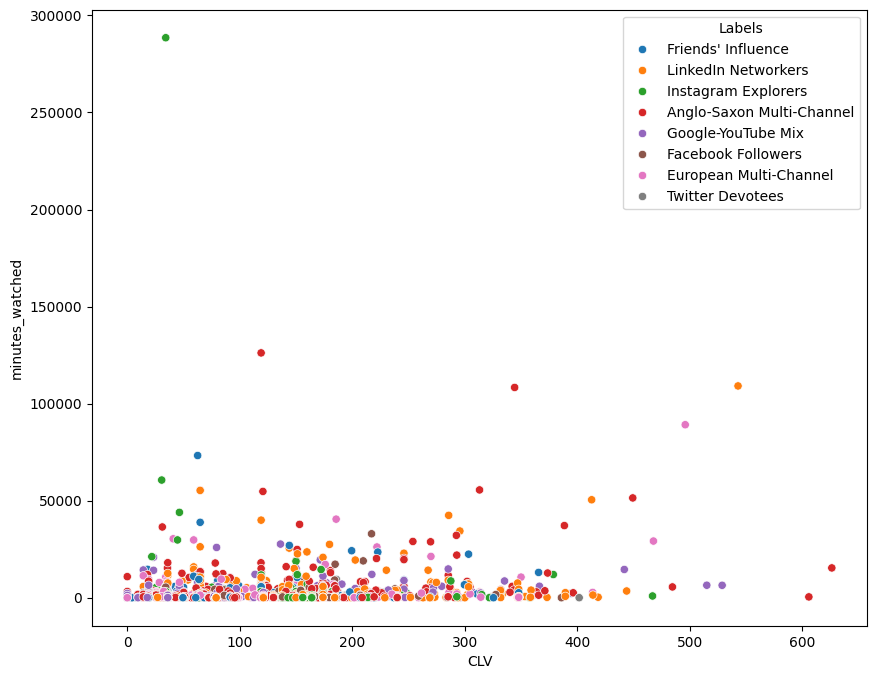

In [352]:
x_axis = df_segm_kmeans['CLV']
y_axis = df_segm_kmeans['minutes_watched']
plt.figure(figsize = (10, 8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm_kmeans['Labels'])
plt.show()